In [1]:
import math
import torch
import gpytorch
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

from GPyEm import GPE_ensemble as GPE

from FSGPLVM import FSGPLVM as LVM

In [2]:
import sklearn.metrics as sk

### Fully supervised GPLVM (we should come up with a better acronym/name)

Observations:
$$Y = [y_1,...,y_N], \ y_n \in R^{p}$$
Model parameters
$$X = [x_1,...,x_N], \ x_n \in R^{p\times q}$$
Latent parameters/features
$$L = [l_1,...,l_N], \ l_n \in R^{d }$$
With $d<q$ and $L\sim N(0,I)$.

We want to find a function $f_\theta$ such that:
$$ Y = f_\theta(X,L)+\epsilon $$
Let's make $f$ a GP, as we like to, with mean $m_\theta(X,L)$ and covariance $K_\theta((X,L),(X',L'))$
We would like to learn $L$ and $\theta$ (the hyper-parameters). 

As a cost function we use the likelihood
$$p(Y,L|X) = p(Y|L,X)p(L) $$
and as $f$ is a GP,
$$p(Y|L,X) \sim N(m_\theta(X,L), K_\theta((X,L),(X,L)))$$

Taking the log we have
$$\log p(Y,L|X) = \log p(Y|L,X)+\log p(L) $$
$$ = -\frac{NP}{2}\log(2\pi)-\frac{1}{2}\log|K_\theta|-\frac{1}{2}(Y-m_\theta(X,L))^\top\ K_\theta^{-1}(Y-m_\theta(X,L))-\frac{N*LDIM}{2}\log(2\pi)-\frac{1}{2}\log|I|-\frac{1}{2}(L)^\top I^{-1}(L)) $$


to calculate $\log |K|$ we use the fact that $\log |K| = 2\Sigma (\log\mathrm{diag}(L)_i)$, where $L$ is the cholesky decomposition of $K$.

In [3]:
def multivariate_ll(y,mu,K,K_inv=None):
    det = 2*torch.sum(torch.log(torch.diag(torch.linalg.cholesky(K))))
    if K_inv==None:
        ll = -((y.shape[0]*y.shape[1])/2)*torch.log(2*torch.tensor(torch.pi))-0.5*y.shape[1]*det-0.5*torch.sum(torch.diag(torch.matmul((y-mu).T,torch.linalg.solve(K,y-mu))))
        #ll = -(y.shape[0]/2)*torch.log(2*torch.tensor(torch.pi))-0.5*det-0.5*torch.matmul((y-mu).T,torch.linalg.solve(K,y-mu))
        
    return ll

In [4]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel



def rbf(X1,L1,X2,L2,scaling,lengthscale,p1,p2):
    X1=X1/torch.sqrt(lengthscale)
    X2=X2/torch.sqrt(lengthscale)
    X_1 = (torch.cat((X1,torch.repeat_interleave(L1,p1,dim=0)),axis=1)).detach().numpy()
    X_2 = (torch.cat((X2,torch.repeat_interleave(L2,p2,dim=0)),axis=1)).detach().numpy()
    rbf = scaling * torch.tensor(rbf_kernel(X_1,X_2, gamma = 1))

    return rbf

def rbf(X1,L1,X2,L2,scaling,lengthscale,p1,p2):
    X_1 = (torch.cat((X1,torch.repeat_interleave(L1,p1,dim=0)),axis=1)/torch.sqrt(lengthscale)).detach().numpy()
    X_2 = (torch.cat((X2,torch.repeat_interleave(L2,p2,dim=0)),axis=1)/torch.sqrt(lengthscale)).detach().numpy()
    rbf = scaling * torch.tensor(rbf_kernel(X_1,X_2, gamma = 1))

    return rbf

def rbf2(X1,X2,scaling,lengthscale):

    X_1 = (X1/torch.sqrt(lengthscale)).detach().numpy()
    X_2 = (X2/torch.sqrt(lengthscale)).detach().numpy()
    rbf = scaling * torch.tensor(rbf_kernel(X_1,X_2, gamma = 1))

    return rbf


def rbf(X1,X2,scaling,lengthscale):

    X_1 = X1/lengthscale
    X_2 = X2/lengthscale
    rbf = scaling * torch.exp(-0.5*torch.cdist(X_1,X_2,p=2)**2)

    return rbf



For the linear kernel we don't really have any separation possibilities that are useful to us from an inverting persepctive, as far as I can tell? 
$$K_{ij}=x_i^\top x_j + l_i^\top l_j$$

So we don't get much in the way of help here.

In [5]:
def linear(X1,L1,X2,L2,X_length,L_length,p1,p2):
    
    L1=L1/torch.sqrt(L_scale)
    X1=X1/torch.sqrt(X_scale)
    X_1 = torch.cat((X1,torch.repeat_interleave(L1,p1)[:,None]),axis=1)

    L2=L2/torch.sqrt(L_scale)
    X2=X2/torch.sqrt(X_scale)
    X_2 = torch.cat((X2,torch.repeat_interleave(L2,p2)[:,None]),axis=1)
    
    rbf =  torch.matmul(X_1, X_2.T) 
    return rbf

sample $L$ and $X$ from $U[-1,1]$

Here we do $x_i \neq x_j$, just for the sake of it

Posterior mean: $$m(X^*,X)+K((X^*,L^*),(X,L))(K((X,L),(X,L))+\sigma^2I)^{-1}(Y-m(X,X))$$

Posterior covar: $$K((X^*,L^*),(X^*,L^*))+\sigma^2 - K((X^*,L^*),(X,L))(K((X,L),(X,L))+\sigma^2I]^{-1}K((X^*,L^*),(X,L))^\top$$

In [6]:
def posterior_theta(Y,X_test,L_test,p_test,X_train,L_train,p_train,scaling,lengthscale,sigma2,mean):
    K = rbf(X_train,L_train,X_train,L_train,scaling,lengthscale,p_train,p_train)+sigma2*torch.eye(X_train.shape[0])
    K_s = rbf(X_test,L_test,X_train,L_train,scaling,lengthscale,p_test,p_train)
    K_ss = rbf(X_test,L_test,X_test,L_test,scaling,lengthscale,p_test,p_test)

    mean_p = mean+torch.matmul(K_s,torch.linalg.solve(K,Y-mean))
    K_p = K_ss-torch.matmul(K_s,torch.linalg.solve(K,K_s.T))+sigma2
    return mean_p, K_p

In [7]:
def posterior_theta(Y,X_test,X_train,scaling,lengthscale,sigma2,mean):
    K = rbf(X_train,X_train,scaling,lengthscale)+sigma2*torch.eye(X_train.shape[0])
    K_s = rbf(X_test,X_train,scaling,lengthscale)
    K_ss = rbf(X_test,X_test,scaling,lengthscale)

    mean_p = mean+torch.matmul(K_s,torch.linalg.solve(K,Y-mean))
    K_p = K_ss-torch.matmul(K_s,torch.linalg.solve(K,K_s.T))+sigma2
    return mean_p, K_p

### Test 1

In [8]:
N = 10 #number of systems
p = 20 #observations per system
alpha=10
beta=-7
zeta=1

In [9]:
L_true=torch.FloatTensor(N, 1).uniform_(1, 4)
L_true =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1]))

In [10]:
L_true

tensor([[ 0.1544],
        [-1.1439],
        [-1.2928],
        [-0.8787],
        [-0.2379],
        [ 0.0497],
        [-1.1381],
        [-0.1084],
        [-0.6153],
        [ 0.2318]])

In [11]:
multivariate_ll(L_true,0,torch.eye(N),K_inv=None)

tensor(-11.9766)

In [12]:

import scipy
np.sum(scipy.stats.multivariate_normal.logpdf(L_true.T.detach().numpy(),cov=np.eye(N)))

-11.976604199007978

In [13]:
X_train=torch.torch.FloatTensor(N*p, 1).uniform_(-2, 2)
X_test=torch.torch.FloatTensor(N*p, 1).uniform_(-2, 2)

In [14]:
L_true[[0]][0]

tensor([0.1544])

In [41]:
def true_func(X,L,alpha,beta,zeta):
    tf = alpha*X*X*L+beta+torch.normal(0,0.0001*torch.ones(X.shape[0],1))
    return tf

In [42]:
lmin=-2
lmax=2

xmin=-2
xmax=2


l_range = torch.linspace(lmin,lmax,100)
x_range = torch.linspace(xmin,xmax,100)

XX,LL  = torch.meshgrid(l_range,x_range)
XXLL = torch.cat([XX.reshape(10000,1),LL.reshape(10000,1)],axis=1)

YY = true_func(XX,LL,alpha,beta,zeta)

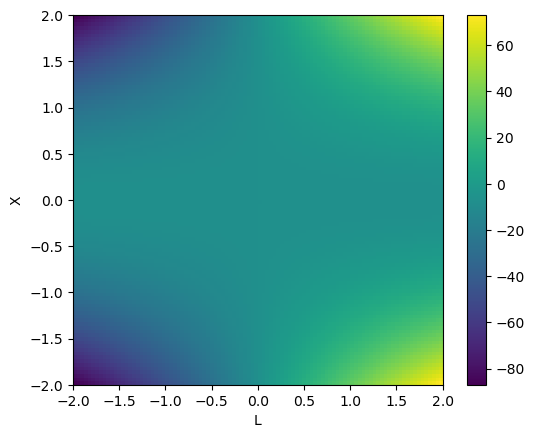

In [43]:
plt.imshow(YY,origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.ylabel('X')
plt.xlabel('L')

plt.colorbar()

In [44]:
y=[]
y_test = []
for i in range(N):
    y.append(true_func(X_train[i*p:(i+1)*p],L_true[[i]],alpha,beta,zeta))
    y_test.append(true_func(X_test[i*p:(i+1)*p],L_true[[i]],alpha,beta,zeta))

In [45]:
Y=torch.cat(y)
Y_test=torch.cat(y_test)

In [46]:
Y.shape

torch.Size([200, 1])

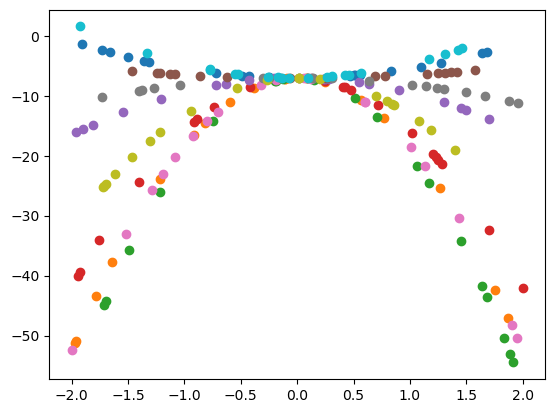

In [47]:
for i in range(N):
    plt.plot(X_train[i*p:(i+1)*p,0].detach().numpy(),Y[i*p:(i+1)*p].detach().numpy(),'o')

In [48]:
Y_mean = Y.mean()
Y_std = Y.std()

X_mean = X_train.mean()
X_std =X_train.std()

#X_train = (X_train-X_mean)/X_std
#X_test = (X_test-X_mean)/X_std

#Y=(Y-Y_mean)/Y_std
#Y_test=(Y_test-Y_mean)/Y_std

In [49]:
X_all_train = (torch.cat((X_train,torch.repeat_interleave(L_true,p,dim=0)),axis=1))
X_all_test = (torch.cat((X_test,torch.repeat_interleave(L_true,p,dim=0)),axis=1))


In [50]:
emulator=GPE.ensemble(X_all_train,Y,mean_func='zero',training_iter=1000)

0


/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


In [51]:
for param_name, param in emulator.models[0].named_parameters():
    print(f'Parameter name: {param_name:42} ')

Parameter name: likelihood.noise_covar.raw_noise           
Parameter name: covar_module.raw_outputscale               
Parameter name: covar_module.base_kernel.raw_lengthscale   


In [52]:
emulator.models[0].covar_module.outputscale
emulator.models[0].covar_module.base_kernel.lengthscale

tensor([[2.0856, 4.0024]], grad_fn=<SoftplusBackward0>)

In [53]:
emulator.models[0].covar_module.outputscale.detach().clone()

tensor(47.0015)

In [54]:
L =torch.normal(0,torch.ones(L_true.shape[0],1)).clone().detach().requires_grad_(True)

XL_train = torch.cat((X_train,torch.repeat_interleave(L,p,dim=0)),axis=1)

In [55]:
LVemulator = LVM.LVE(XL_train,Y,0.001,p,N,1,training_iter=6000,lr=1e-5)

tensor(29882.4004, grad_fn=<NegBackward0>)
tensor(28673.1914, grad_fn=<NegBackward0>)
tensor(27464.5332, grad_fn=<NegBackward0>)
tensor(26251.2461, grad_fn=<NegBackward0>)
tensor(25046.5293, grad_fn=<NegBackward0>)
tensor(23850.8906, grad_fn=<NegBackward0>)


In [56]:
LVemulator.optimise(500000,1e-5)

tensor(22667.2168, grad_fn=<NegBackward0>)
tensor(21507.6602, grad_fn=<NegBackward0>)
tensor(20361.5684, grad_fn=<NegBackward0>)
tensor(19258.6875, grad_fn=<NegBackward0>)
tensor(18179.1270, grad_fn=<NegBackward0>)
tensor(17133.4551, grad_fn=<NegBackward0>)
tensor(16114.7754, grad_fn=<NegBackward0>)
tensor(15127.9258, grad_fn=<NegBackward0>)
tensor(14159.8711, grad_fn=<NegBackward0>)
tensor(13206.9492, grad_fn=<NegBackward0>)
tensor(12281.3555, grad_fn=<NegBackward0>)
tensor(11380.2871, grad_fn=<NegBackward0>)
tensor(10512.6094, grad_fn=<NegBackward0>)
tensor(9676.7578, grad_fn=<NegBackward0>)
tensor(8891.3164, grad_fn=<NegBackward0>)
tensor(8152.9565, grad_fn=<NegBackward0>)
tensor(7444.0679, grad_fn=<NegBackward0>)
tensor(6794.2178, grad_fn=<NegBackward0>)
tensor(6192.0605, grad_fn=<NegBackward0>)
tensor(5641.4424, grad_fn=<NegBackward0>)
tensor(5142.4092, grad_fn=<NegBackward0>)
tensor(4689.6152, grad_fn=<NegBackward0>)
tensor(4281.2017, grad_fn=<NegBackward0>)
tensor(3912.2107, gra

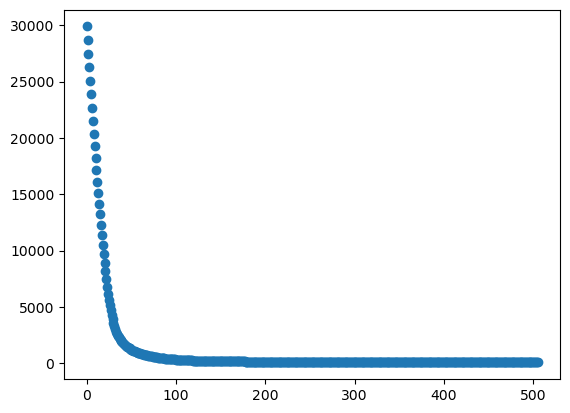

In [57]:
plt.plot(LVemulator.history_gd[::1000],'o')

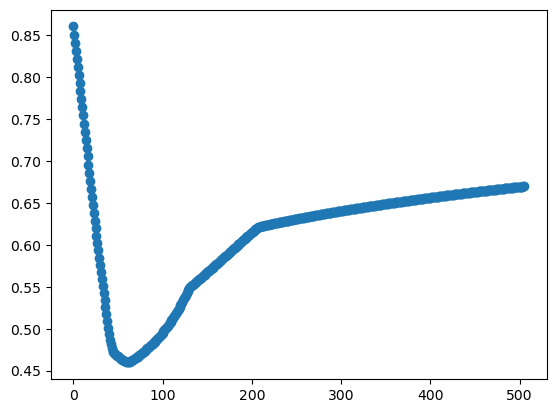

In [58]:
plt.plot(torch.cat(LVemulator.lengths)[::1000],'o')

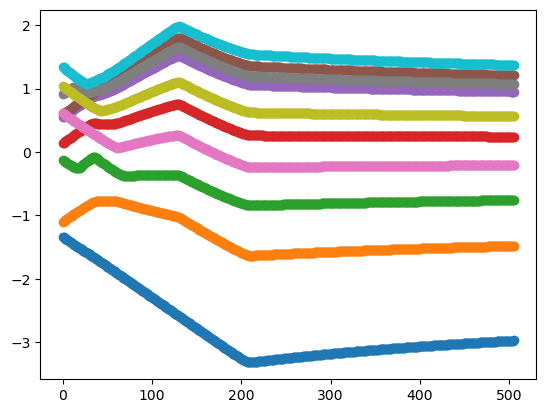

In [59]:
plt.plot(torch.cat(LVemulator.Ls,axis=1).T[::1000],'o')

In [60]:
LVemulator.L

tensor([[-2.9748],
        [-1.4807],
        [-0.7579],
        [ 0.2431],
        [ 0.9538],
        [ 1.2121],
        [-0.2073],
        [ 1.0748],
        [ 0.5677],
        [ 1.3720]], requires_grad=True)

In [61]:
p

20

In [62]:
XL_test = torch.cat((X_test,torch.repeat_interleave(LVemulator.L,p,dim=0)),axis=1)

In [63]:
LVemulator.L

tensor([[-2.9748],
        [-1.4807],
        [-0.7579],
        [ 0.2431],
        [ 0.9538],
        [ 1.2121],
        [-0.2073],
        [ 1.0748],
        [ 0.5677],
        [ 1.3720]], requires_grad=True)

In [64]:
LVemulator.MSE(XL_test,Y_test)

tensor([0.0703], grad_fn=<MeanBackward1>)

In [65]:
LVemulator.R2(XL_test,Y_test)

tensor([0.9331], grad_fn=<RsubBackward1>)

In [66]:
emulator.R2(X_all_test,Y_test)

tensor([1.0000], grad_fn=<RsubBackward1>)

In [67]:
LVemulator.predict(XXLL)

(tensor([[-40.1216],
         [-41.2947],
         [-42.4304],
         ...,
         [ 26.4674],
         [ 28.3867],
         [ 30.3088]], grad_fn=<CopySlices>),
 tensor([[0.2924],
         [0.2879],
         [0.2838],
         ...,
         [1.4940],
         [1.6318],
         [1.7805]], grad_fn=<CopySlices>))

In [68]:
p_new = 40
X_new=torch.torch.FloatTensor(p_new, 1).uniform_(-3, 3)
L_new_true =torch.normal(0,torch.ones(1,L_true.shape[1]))
L_new =torch.normal(0,torch.ones(1,L_true.shape[1])).clone().detach().requires_grad_(True)

#L_new_true = LVemulator.L[[0]]

Y_new=true_func(X_new,L_new_true,alpha,beta,zeta)

In [69]:
XL_new = torch.cat((X_new,torch.repeat_interleave(L_new,p_new,dim=0)),axis=1)

In [70]:
X_std

tensor(1.1340)

In [71]:
XL_new[:,0] = (XL_new[:,0]-X_mean)/X_std

In [72]:
LVemulator.R2(XL_new,Y_new)

tensor([-4.2058], grad_fn=<RsubBackward1>)

In [73]:
i=0

In [74]:
lengthscale_in=torch.cat([LVemulator.lengthscale[i],LVemulator.L_length*torch.ones(LVemulator.L_size)])

In [75]:
m_p,k_p=LVemulator.posterior_theta(LVemulator.Y[:,[i]],XL_new,LVemulator.XL,LVemulator.scale[i],lengthscale_in,100,LVemulator.mean)

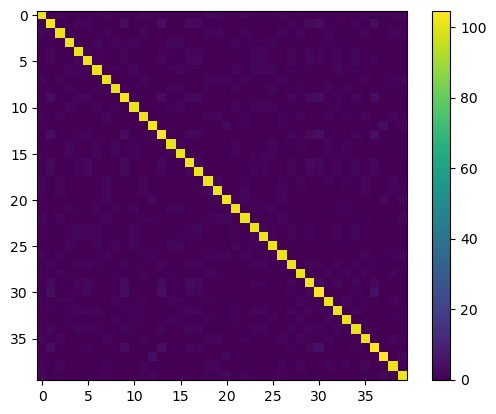

In [76]:
plt.imshow(k_p.detach().numpy())
plt.colorbar()

In [77]:
torch.linalg.cholesky(k_p)

tensor([[ 1.0082e+01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.2021e-04,  1.0163e+01,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.3091e-01,  1.2083e-03,  1.0082e+01,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 1.9801e-02,  8.4358e-05, -2.0554e-02,  ...,  1.0185e+01,
          0.0000e+00,  0.0000e+00],
        [ 8.6828e-02,  2.6498e-03,  1.4799e-01,  ..., -1.7272e-02,
          1.0073e+01,  0.0000e+00],
        [ 1.2930e-01, -3.4388e-04,  5.1088e-02,  ...,  1.3396e-01,
          9.8575e-03,  1.0087e+01]], grad_fn=<LinalgCholeskyExBackward0>)

In [78]:
L_new=LVemulator.cutting_feedback(XL_new,Y_new,100000,1e-4)

tensor(216330.9375, grad_fn=<NegBackward0>)
tensor(214546.1875, grad_fn=<NegBackward0>)
tensor(215216.4062, grad_fn=<NegBackward0>)
tensor(212715.9062, grad_fn=<NegBackward0>)
tensor(211918.1719, grad_fn=<NegBackward0>)
tensor(210530.4688, grad_fn=<NegBackward0>)
tensor(209299.2656, grad_fn=<NegBackward0>)
tensor(209462.2188, grad_fn=<NegBackward0>)
tensor(207843.9688, grad_fn=<NegBackward0>)
tensor(207398.4219, grad_fn=<NegBackward0>)
tensor(206060.3438, grad_fn=<NegBackward0>)
tensor(204392.1875, grad_fn=<NegBackward0>)
tensor(202616.6094, grad_fn=<NegBackward0>)
tensor(202015.5156, grad_fn=<NegBackward0>)
tensor(201520.1094, grad_fn=<NegBackward0>)
tensor(200933.8125, grad_fn=<NegBackward0>)
tensor(199309.5312, grad_fn=<NegBackward0>)
tensor(198290.1406, grad_fn=<NegBackward0>)
tensor(197128.8438, grad_fn=<NegBackward0>)
tensor(197186.6250, grad_fn=<NegBackward0>)
tensor(195493.9375, grad_fn=<NegBackward0>)
tensor(194078.1875, grad_fn=<NegBackward0>)
tensor(193932.8594, grad_fn=<Neg

In [79]:
XL_new = torch.cat((X_new,torch.repeat_interleave(L_new,p_new,dim=0)),axis=1)

In [80]:
LVemulator.R2(XL_new,Y_new)

tensor([-1.7132], grad_fn=<RsubBackward1>)

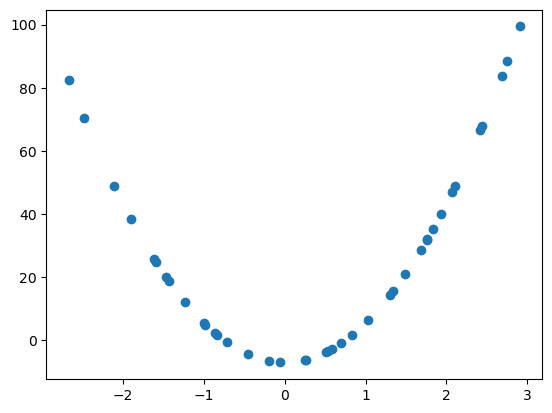

In [81]:
plt.plot(X_new[:,0].detach().numpy(),Y_new.detach().numpy(),'o')

In [ ]:
def cf_cost(Y_new,X_new,L_new,Y_train,X_train,L_train,scaling,lengthscale,sigma2,p_train,p_new,mean):
    
    
    mean_p,K_p = posterior_theta(Y_train,X_new,L_new,p_new,X_train,L_train,p_train,scaling,lengthscale,sigma2,mean)
    
    #K_inv=torch.kron(torch.linalg.inv(K_x),torch.linalg.inv(K_L))
    #K_inv=torch.kron(torch.linalg.inv(K_L),torch.linalg.inv(K_x))
    #print(torch.linalg.det(K))
    c = multivariate_ll(Y_new,mean_p,K_p)  + multivariate_ll(L_new,0,torch.eye(L_new.shape[0])) # multivariate_ll(torch.repeat_interleave(L,x.shape[0])[:,None],0,torch.eye(inp.shape[0]))
    #print(multivariate_ll(Y_new,mean_p,K_p))
    #print(multivariate_ll(L_new,0,torch.eye(L_new.shape[0])))
    return -c

In [ ]:
cf_cost(Y_new,X_new,L_new,Y,X_train,L,scaling,lengthscale,sigma2,p,p_new,mean)

In [ ]:
mean_p,K_p = posterior_theta(Y,X_new,L_cf,p_new,X_train,L,p,scaling,lengthscale,sigma2,mean)

In [ ]:
plt.imshow(K_p.detach().numpy())

In [ ]:
mean_p

In [ ]:
Y_new

In [ ]:
L_cf =torch.normal(0,torch.ones(1,L_true.shape[1])).clone().detach().requires_grad_(True)
#L_cf = (L[[1]]).clone().detach().requires_grad_(True)

In [ ]:
cf_cost(Y_new,X_new,L_cf,Y,X_train,L,scaling,lengthscale,sigma2,p,p_new,mean)

In [ ]:

cf = torch.optim.Adam([L_cf], lr=1e-5)
history_cf = []

for i in range(100000):
    cf.zero_grad()
    objective = cf_cost(Y_new,X_new,L_cf,Y,X_train,L,scaling,lengthscale,sigma2,p,p_new,mean)
    objective.backward()
    cf.step()
    history_cf.append(objective.item())
    if i%1000 ==0:
        m_new, K_new = posterior_theta(Y,X_new,L_cf,p_new,X_train,L,p,scaling,lengthscale,sigma2,mean)
        print(1-(((m_new-Y_new)**2).mean()/Y_new.std()**2),objective)

    if (i>1) and (np.abs(history_cf[-1] - history_cf[-2]) < .00000000001):
        print("Convergence achieved in ", i+1, " iterations")
        print("-LogL Value: ", objective.item())
        break


In [ ]:
L_cf

In [ ]:
L[[1]]

In [ ]:
m_new, K_new = posterior_theta(Y,X_new,L_cf,p_new,X_train,L,p,scaling,lengthscale,sigma2,mean)

In [ ]:
K_new.detach().numpy()

In [ ]:
multivariate_ll(Y_new,m_new, K_new) + multivariate_ll(L_cf,0,torch.eye(L_new.shape[0]))

In [ ]:
multivariate_ll(Y_new,m_new, K_new) 

In [ ]:
multivariate_ll(L_cf,0,torch.eye(L_new.shape[0]))

In [ ]:
1-(((m_new-Y_new)**2).mean())/Y_new.std()

In [ ]:
m_new

In [ ]:
Y_new

In [ ]:
mean